# Import Dependencies

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

    
np.set_printoptions(threshold=50, linewidth=160, suppress=True)
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load Data

In [98]:
x_train_df = pd.read_csv("x_train.csv")
y_train_df = pd.read_csv("y_train.csv")
x_test_df  = pd.read_csv("x_test.csv")

print(x_train_df.shape, y_train_df.shape, x_test_df.shape)
x_train_df.head(2)

(5557, 32) (5557, 5) (1197, 32)


,author,title,passage_id,text,char_count,word_count,sentence_count,avg_word_length,avg_sentence_length,type_token_ratio,...,readability_RIX,readability_DaleChallIndex,info_characters_per_word,info_syll_per_word,info_words_per_sentence,info_type_token_ratio,info_characters,info_syllables,info_words,info_wordtypes
0,A. A. Milne,The Red House Mystery,618,"""Yes.... What sort of terms was he on with the...",493.0,119.0,9.0,3.428571,13.222222,0.655462,...,7.0,11.687683,3.781250,1.041667,96.0,0.760417,363.0,100.0,96.0,73.0
1,A. A. Milne,The Red House Mystery,685,Perhaps I should say that it was Mark's priva...,318.0,61.0,5.0,4.327869,12.200000,0.786885,...,15.0,9.823789,4.722222,1.407407,54.0,0.833333,255.0,76.0,54.0,45.0


# Load BERT EMbeddings

In [99]:
def load_npz_array(path):
    f = np.load(path)
    # Be robust to unknown key names: pick the first array-like
    if isinstance(f, np.lib.npyio.NpzFile):
        for k in f.files:
            arr = f[k]
            if isinstance(arr, np.ndarray):
                return arr
        raise ValueError(f"No ndarray found in {path}")
    # If someone passes .npy by mistake
    if isinstance(f, np.ndarray):
        return f
    raise ValueError(f"Unsupported format for {path}")

E_tr = load_npz_array("x_train_BERT_embeddings.npz")
E_te = load_npz_array("x_test_BERT_embeddings.npz")

print("Embeddings shapes:", E_tr.shape, E_te.shape)





Embeddings shapes: (5557, 768) (1197, 768)


### Map Labels to Reading Levels & Define Groups for GroupKFold (AUTHOR)

In [100]:
COARSE_TO_INT = {"Key Stage 2-3": 0, "Key Stage 4-5": 1}
y = y_train_df["Coarse Label"].map(COARSE_TO_INT).astype(int).values
groups = x_train_df["author"].astype(str).values

print("y shape:", y.shape, "  #unique authors:", x_train_df["author"].nunique())


y shape: (5557,)   #unique authors: 140


### (OPTIONAL) - Isolate NUMERIC COLUMNS

In [30]:
KEY_COLS = ["author", "title", "passage_id"]
TEXT_COL = "text"

numeric_cols = [
    c for c in x_train_df.columns
    if c not in KEY_COLS + [TEXT_COL]
    and pd.api.types.is_numeric_dtype(x_train_df[c])
]

print("# numeric features:", len(numeric_cols))
print("First 12 numeric columns:", numeric_cols[:12])


# numeric features: 28
First 12 numeric columns: ['char_count', 'word_count', 'sentence_count', 'avg_word_length', 'avg_sentence_length', 'type_token_ratio', 'pronoun_freq', 'function_words_count', 'punctuation_frequency', 'sentiment_polarity', 'sentiment_subjectivity', 'readability_Kincaid']


## (Optional) Build Numeric Matrices (Train/Test)

In [46]:
X_num_tr = x_train_df[numeric_cols].to_numpy(dtype=float)
X_num_te = x_test_df[numeric_cols].to_numpy(dtype=float)

print("X_num_tr:", X_num_tr.shape, "  X_num_te:", X_num_te.shape)


X_num_tr: (5557, 28)   X_num_te: (1197, 28)


## Set C Values for cross fold search

In [83]:
C_values = np.logspace(-5, 1, 9)

#  Cross Validation Loop

In [ ]:
cv = GroupKFold(n_splits=5)
mean_train_auc, mean_val_auc = [], []

for C in C_values:
    train_aucs, val_aucs = [], []

    # splits data into train/val folds with author grouping
    for tr_idx, va_idx in cv.split(E_tr, y, groups=groups):
        Xtr, Xva = E_tr[tr_idx], E_tr[va_idx]
        ytr, yva = y[tr_idx], y[va_idx]

        # Scale embeddings within each fold to avoid leakage

        scaler = StandardScaler() 
        Xtr_s = scaler.fit_transform(Xtr) # learn scaling for each column (mean, standard dev.)
        Xva_s = scaler.transform(Xva) # apply learned scaling to each column in the data

        # Using both l1 and l2 penalties to eliminate weak features
        clf = LogisticRegression(
            solver="lbfgs",
            penalty="l2",
            C=C,
            max_iter=1000,
            random_state=42,
        )
        clf.fit(Xtr_s, ytr)


        
        p_tr = clf.predict_proba(Xtr_s)[:, 1]
        p_va = clf.predict_proba(Xva_s)[:, 1]

        train_aucs.append(roc_auc_score(ytr, p_tr))
        val_aucs.append(roc_auc_score(yva, p_va))

    mean_train_auc.append(np.mean(train_aucs))
    mean_val_auc.append(np.mean(val_aucs))
    print(f"C={C:8.2e}  train_AUC={np.mean(train_aucs):.4f}  val_AUC={np.mean(val_aucs):.4f}")

best_idx = int(np.argmax(mean_val_auc))
best_C = float(C_values[best_idx])
print(f"\nBest C={best_C:.3e} (mean val AUROC={mean_val_auc[best_idx]:.6f})")



C=1.00e-05  train_AUC=0.7804  val_AUC=0.7685
C=5.62e-05  train_AUC=0.7934  val_AUC=0.7707
C=3.16e-04  train_AUC=0.8160  val_AUC=0.7692
C=1.78e-03  train_AUC=0.8459  val_AUC=0.7633
C=1.00e-02  train_AUC=0.8745  val_AUC=0.7510
C=5.62e-02  train_AUC=0.8913  val_AUC=0.7340
C=3.16e-01  train_AUC=0.8962  val_AUC=0.7208
C=1.78e+00  train_AUC=0.8968  val_AUC=0.7158
C=1.00e+01  train_AUC=0.8968  val_AUC=0.7146

Best C=5.623e-05 (mean val AUROC=0.770675)


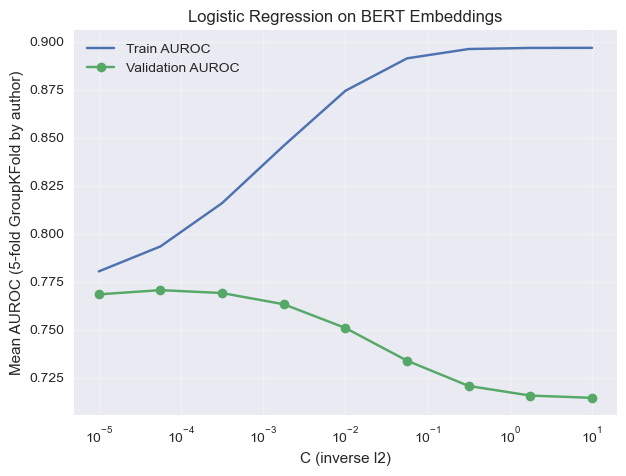

In [93]:
plt.figure(figsize=(7,5))
plt.semilogx(C_values, mean_train_auc, marker='x', label='Train AUROC')
plt.semilogx(C_values, mean_val_auc, marker='o', label='Validation AUROC')
plt.xlabel("C (inverse l2)")
plt.ylabel("Mean AUROC (5-fold GroupKFold by author)")
plt.title("Logistic Regression on BERT Embeddings")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [87]:
# Scale on FULL train embeddings, then transform test embeddings
scaler_final = StandardScaler()
Etr_s = scaler_final.fit_transform(E_tr)
Ete_s = scaler_final.transform(E_te)

clf_final = LogisticRegression(
    solver="lbfgs",
    penalty="l2",
    C=best_C,
    max_iter=1000,
    random_state=42,
)
clf_final.fit(Etr_s, y)

yproba_test = clf_final.predict_proba(Ete_s)[:, 1]
np.savetxt("yproba1_test.txt", yproba_test, fmt="%.6f")

print(f"Final model trained with C={best_C:.3f}")
print("Wrote yproba1_test.txt")
print("Preview:", np.round(yproba_test[:5], 4))


Final model trained with C=0.000
Wrote yproba1_test.txt
Preview: [0.7163 0.7282 0.6249 0.7332 0.7041]


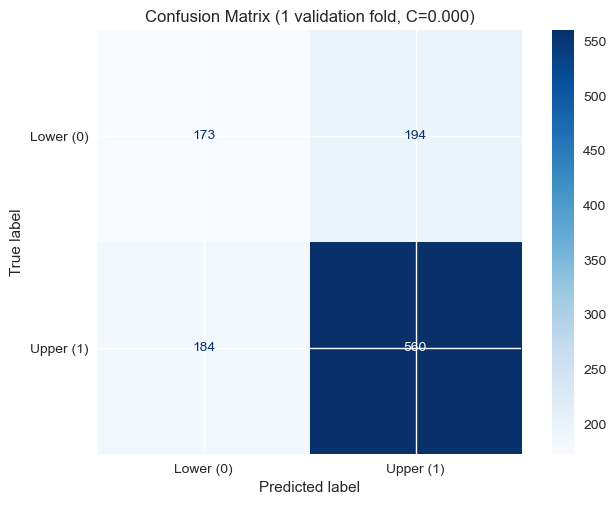

Confusion matrix counts:
[[173 194]
 [184 560]]
Fold AUROC: 0.6723


In [95]:
# Quick confusion matrix on one validation fold (author-level split)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pick one split from GroupKFold (first fold for simplicity)
cv = GroupKFold(n_splits=5)
first_fold = next(cv.split(X_num_tr, y, groups=groups))
tr_idx, va_idx = first_fold

Xtr, Xva = X_num_tr[tr_idx], X_num_tr[va_idx]
ytr, yva = y[tr_idx], y[va_idx]

# Scale within this fold
scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr)
Xva_s = scaler.transform(Xva)

# Train with the chosen best_C
clf_fold = LogisticRegression(
    solver="lbfgs",
    penalty="l2",
    C=best_C,
    max_iter=1000,
    random_state=RANDOM_STATE,
)
clf_fold.fit(Xtr_s, ytr)

# Predict and build confusion matrix
y_pred = clf_fold.predict(Xva_s)
cm = confusion_matrix(yva, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Lower (0)", "Upper (1)"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (1 validation fold, C={best_C:.3f})")
plt.show()

# Print numeric summary
print("Confusion matrix counts:")
print(cm)
print(f"Fold AUROC: {roc_auc_score(yva, clf_fold.predict_proba(Xva_s)[:,1]):.4f}")
